**未知物种问题**
从beta分布推广到dirichlet分布。

In [1]:
from thinkbayes2 import *
from scipy import stats
from matplotlib import pyplot as plt
import numpy as np
import thinkplot

In [9]:
# 默认已知有三个物种
d = Dirichlet(3)

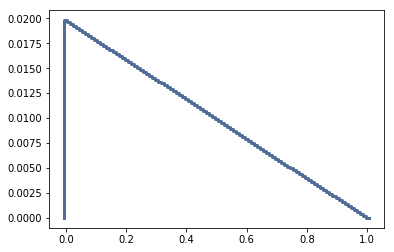

In [11]:
# 物种1的比例的概率分布
s1 = d.MarginalBeta(0)
thinkplot.Pmf(s1.MakePmf())
plt.show()

In [14]:
# 各个物种最有可能出现的比例
for i in range(d.n):
    print("物种{}:{}".format(i,d.MarginalBeta(i).Mean()))

物种0:0.3333333333333333
物种1:0.3333333333333333
物种2:0.3333333333333333


In [15]:
d.Update([3,2,1])

物种0:0.4444444444444444
物种1:0.3333333333333333
物种2:0.2222222222222222


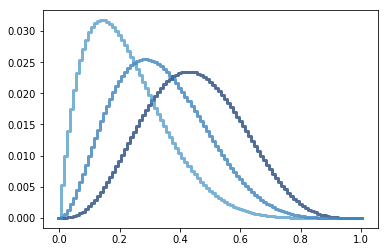

In [16]:
# 各个物种最有可能出现的比例
for i in range(d.n):
    print("物种{}:{}".format(i,d.MarginalBeta(i).Mean()))


thinkplot.Pmfs([d.MarginalBeta(i).MakePmf(label=str(i)) for i in range(3)])
plt.show()

**多层贝叶斯**

物种数目是一个未知先验，接下来对物种数目建模。

In [101]:
import scipy
class Species(Suite):
    def __init__(self, d):
        self.par_dist = d
        hypo = {Dirichlet(n):prob for n, prob in d.items()}
        Suite.__init__(self, hypo)
        self.Normalize()
    
    def Likelihood(self, data, hypo):
        # data是物种数列表，
        # hypo是一个n控制下的Dirichlet分布
        # 这里和之前的那个分层模型不一样
        # like = hypo.Update(data)
        # return like
        dirichlet = hypo
        like = 0
        for i in range(2000):
            like += dirichlet.Likelihood(data)
        
        k = len(data)
        like *= scipy.special.comb(dirichlet.n, k)
        return like
    
    def Update(self, data):
        Suite.Update(self, data)
        for hypo in self.Values():
            if hypo.n >= len(data):
                hypo.Update(data)
    
    def DistOfCurrentLayer(self):
        return MakePmfFromItems([(dirichlet.n, prob) for dirichlet, prob in self.Items()])
    

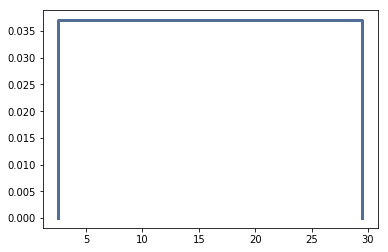

In [102]:
d = Pmf(range(3,30))
species = Species(d.d)
thinkplot.Pmf(species.DistOfCurrentLayer())
plt.show()

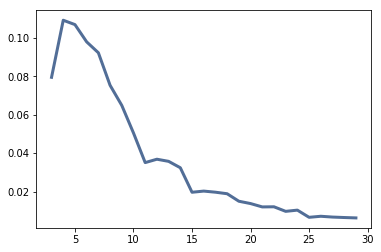

In [103]:
species.Update([3,2,1])
thinkplot.Pdf(species.DistOfCurrentLayer())
plt.show()

# 注意
Beta 和 Dirichlet 在thinkbayes中是两个特殊的类，并不是Pmf的子类，而是仅仅封装了两个分布自身的参数，Beta中没有Likelihood，Dirichlet中虽然有Likelihood，但是就是一个该分布中采样值的似然，而不是该分布的似然。

在上面如果想要求Dirichlet分布的似然，需要不停的采样并求和，此时得到的似然结果不一定满足概率形式，是一个正比于似然的数，采样次数越多越精确，这个过程实际就是隐含的求Dirichlet的Pmf。

